<h1>ENSO RMSE and SPREAD (Do Not Distribute)</h1>

In [1]:
import os
import sys

# Point to root directory of repository
root_dir = os.path.join(os.getcwd(), '..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)
    
from src.datareader import datareader as dr
from src.util import util, stats

<h5>Get data readers</h5>

In [2]:
ufs_models = ['baseline', 'beta.0.1', 'c96_beta.0.1', 'cpc_ics']
ufs_data_readers = [dr.getDataReader(datasource='UFS',
                                     filename=f'experiments/phase_1/{m}/atm_monthly.zarr',
                                     model='atm')
                    for m in ufs_models]

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/baseline/atm_monthly.zarr
Standardizing coordinate system
Dataset ready.
Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/beta.0.1/atm_monthly.zarr
Standardizing coordinate system
Dataset ready.
Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/c96_beta.0.1/atm_monthly.zarr
Standardizing coordinate system
Dataset ready.
Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/cpc_ics/atm_monthly.zarr
Standardizing coordinate system
Dataset ready.


In [3]:
era5_data_reader = dr.getDataReader(datasource='ERA5')

No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr
Standardizing coordinate system
Dataset ready.


In [4]:
ufs_vars = ['tmpsfc', 'tsfc']
era5_var = 'sea_surface_temperature'

<h5>Define time period</h5>

In [5]:
time_range = ("1994-05-01","2021-10-31T23")
initmonths = (11,)

<h5>Define nino 3.4 region</h5>

In [6]:
region = {
    'latmin': -5.0,
    'latmax': 5.0,
    'lonmin': 190.0,
    'lonmax':240.0
}

<h5>Get climatology statistics for nino 3.4</h5>

In [7]:
# Enter a list of members, like [1, 2, 6, 8, ens_avg]
# Note that 'ens_avg' is a special keyword in the ensuing code.
# If you include 'ens_avg' in the list of members,
# then the Ensemble Average will be listed under member = -1
members = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'ens_avg']

<h5>Statistical accumulation will take a few minutes... please be patient.</h5>

In [8]:
%%capture captured_output

ufs_dss = []
ufs_var_list = []
ufs_stats = []

for this_dr in ufs_data_readers:
    
    for this_var in ufs_vars:                                                                                   
        if this_var in list(this_dr.dataset().keys()):                                                               
            ufs_var = this_var

    ufs_var_list.append(ufs_var)  # Keep track of which ufs variable name is used here.
    
    # Get datasets
    this_ds = util.retrieve_ufs_dataset(this_dr, ufs_var, time_range, members, region, initmonths=initmonths)
    ufs_dss.append(this_ds)
    
    # Calculate climatology statistics
    ufs_stats.append(stats.calc_climatology(this_ds, area_mean=True))

In [9]:
era5_ds = era5_data_reader.retrieve(var=era5_var,
                                    lat=(region['latmin'], region['latmax']),
                                    lon=(region['lonmin'], region['lonmax']),
                                    time=time_range)

In [10]:
# ERA5 climatology statistics
era5_stats = stats.calc_climatology(era5_ds, area_mean=True)

<h3>Accumulating RMSE and SPREAD statistics for each UFS model.  This may take some time!</h3>

In [11]:
rmses = [stats.calc_rmse_spread(ufs_dss[i], ufs_var_list[i], ufs_stats[i], era5_ds, era5_var, era5_stats)
         for i in range(len(ufs_dss))]

Number of ensemble members: 11
Number of years: 27
Accumulating Statistics...
Finished.
Number of ensemble members: 11
Number of years: 27
Accumulating Statistics...
Finished.
Number of ensemble members: 11
Number of years: 27
Accumulating Statistics...
Finished.
Number of ensemble members: 11
Number of years: 27
Accumulating Statistics...
Finished.


<h2>Plot statistics</h2>

<module 'matplotlib.pyplot' from '/home/thamzey/miniforge2/envs/ufs_model_evaluation_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

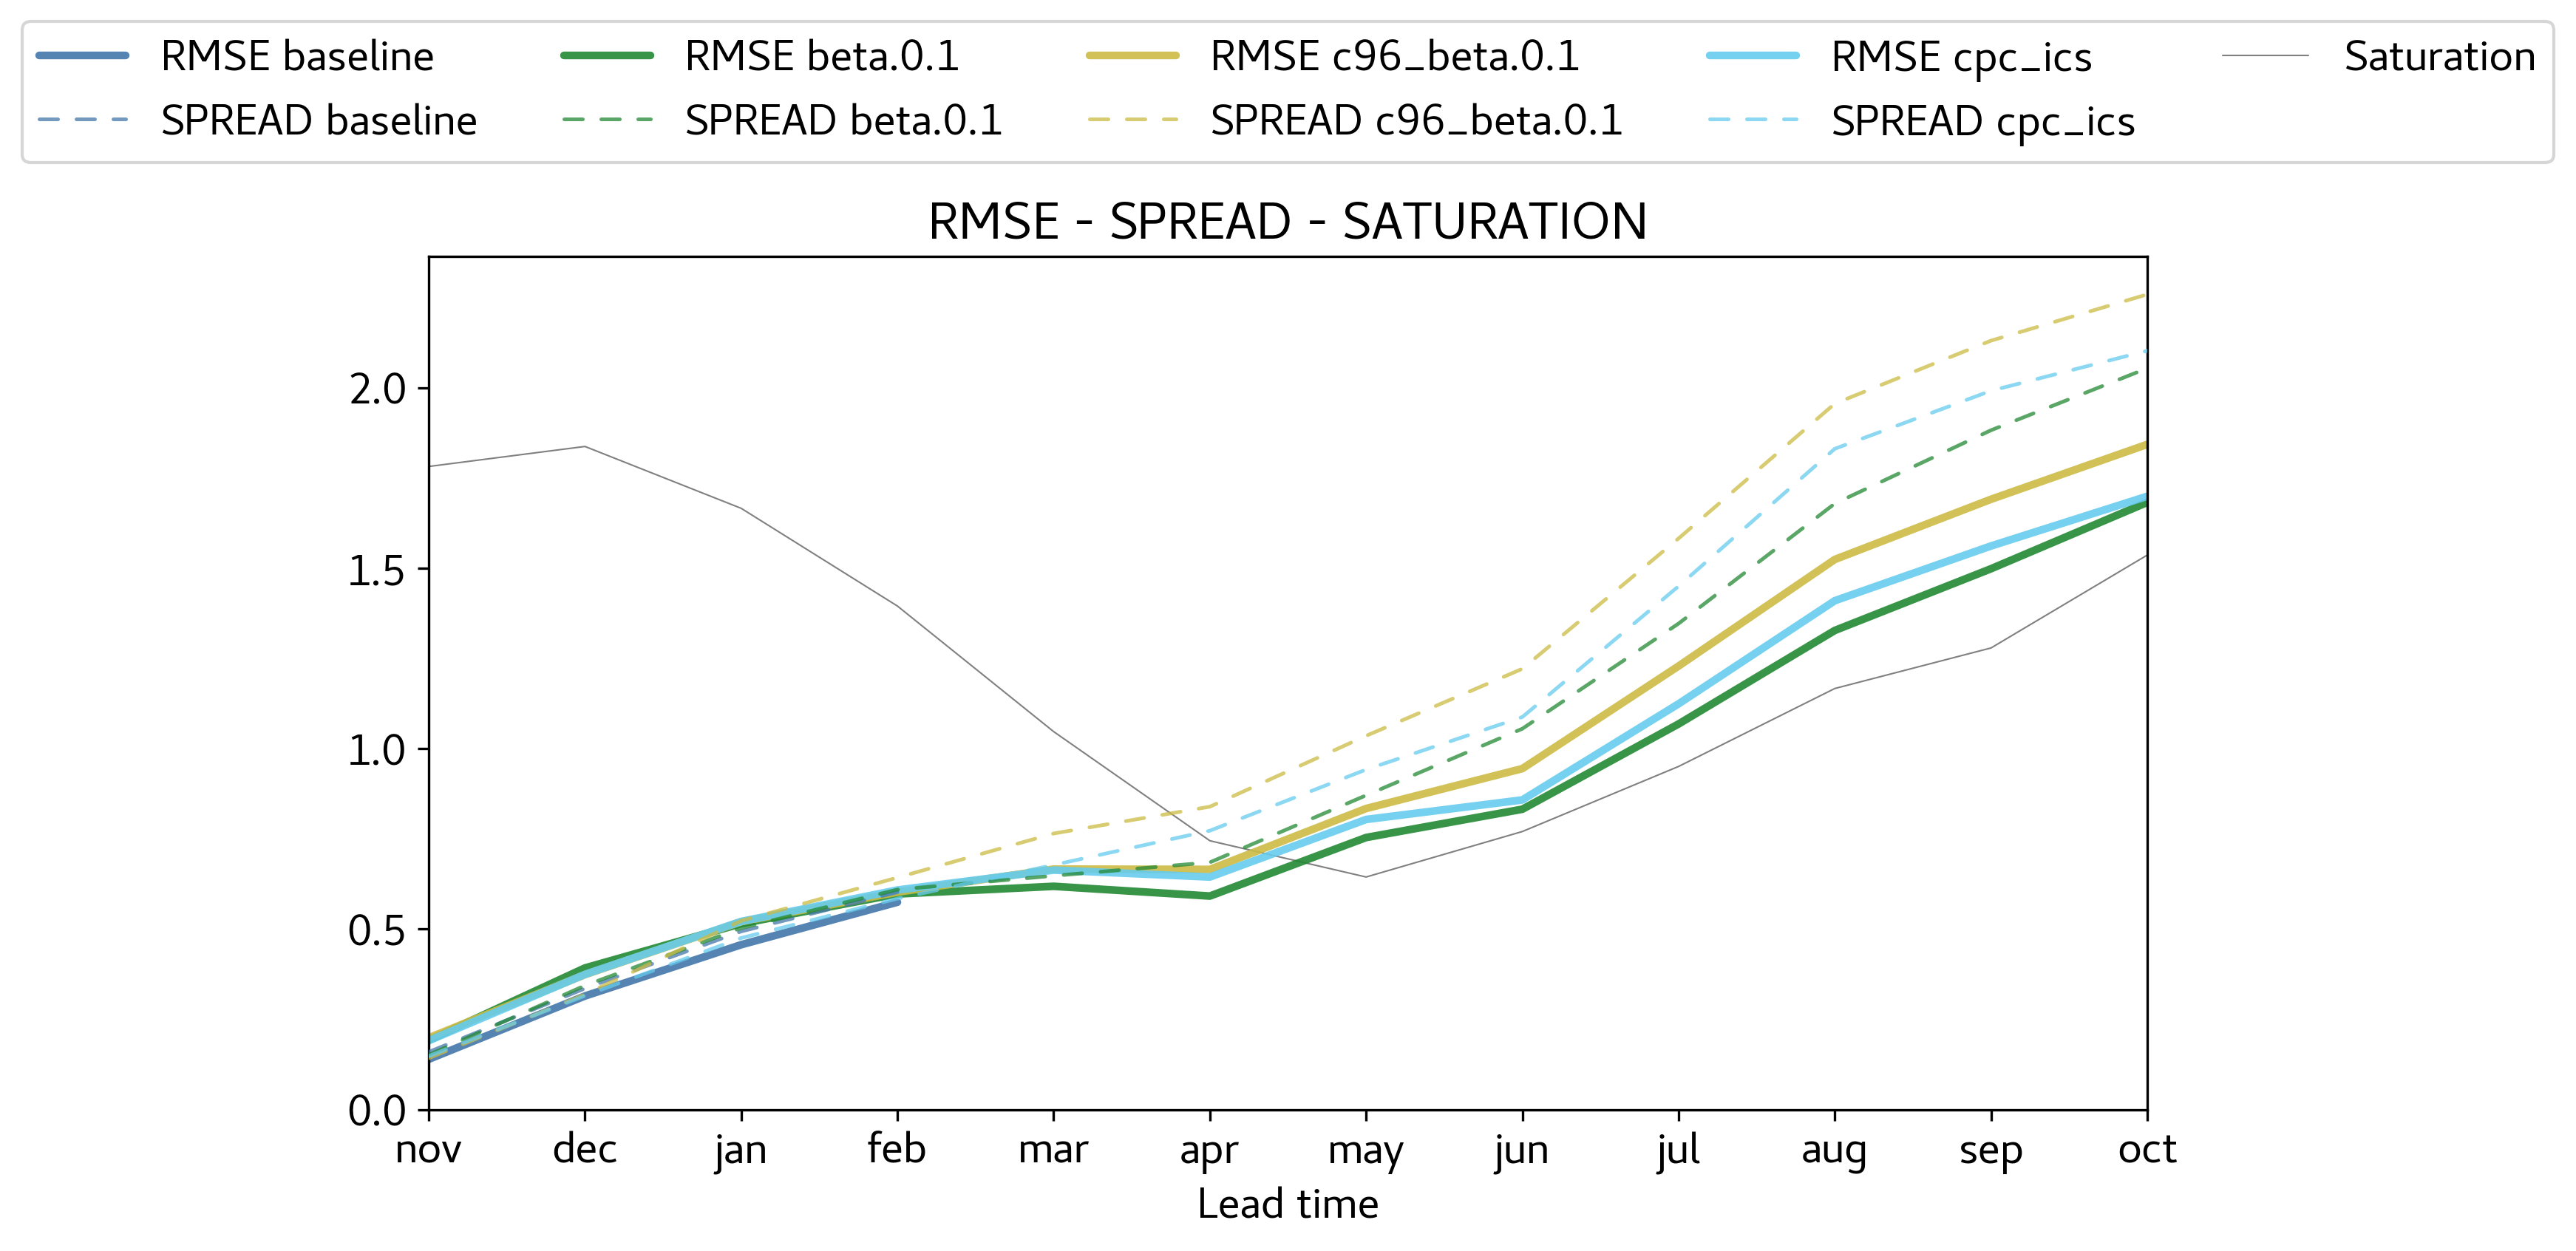

In [12]:
stats.plot_rmse_spread(rmses,
                       ufs_models,
                       rmse_only=False,
                       spread_only=False,
                       verif_stats=era5_stats,
                       title='RMSE - SPREAD - SATURATION')